## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2, l2_ratio=1e-4, bn = True):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            if bn:
                x = BatchNormalization()(x)
            
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
            if bn:
                x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4]
DROPOUT_EXP= [0.1, 0.25]
BN = [True, False]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio, dropout_ratio, bn_flag in itertools.product(L2_EXP, DROPOUT_EXP, BN):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f, Dropout = %.6f, BN = %s" % (regulizer_ratio, dropout_ratio, ('On' if bn_flag else 'Off')))
    model = build_mlp(input_shape=x_train.shape[1:],drp_ratio= dropout_ratio, l2_ratio=regulizer_ratio, bn = bn_flag)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s, drp-%s, BN-%s" % (str(regulizer_ratio), str(dropout_ratio), ('On' if bn_flag else 'Off'))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0723 18:39:47.524756 35980 deprecation_wrapper.py:119] From c:\users\kehua\.conda\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0723 18:39:47.525758 35980 deprecation_wrapper.py:119] From c:\users\kehua\.conda\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 18:39:47.559789 35980 deprecation_wrapper.py:119] From c:\users\kehua\.conda\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 18:39:47.560790 35980 deprecation_wrapper.py:119] From c:\users\kehua\.conda\envs\keras\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instea

Experiment with Regulizer = 0.010000, Dropout = 0.100000, BN = On


W0723 18:39:47.853055 35980 deprecation_wrapper.py:119] From c:\users\kehua\.conda\envs\keras\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 18:39:47.949142 35980 deprecation.py:323] From c:\users\kehua\.conda\envs\keras\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
__________

Epoch 46/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.4783 - acc: 0.5247 - val_loss: 1.6143 - val_acc: 0.4757
Epoch 47/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.4833 - acc: 0.5234 - val_loss: 1.6684 - val_acc: 0.4508
Epoch 48/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.4797 - acc: 0.5238 - val_loss: 1.7558 - val_acc: 0.4350
Epoch 49/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.4758 - acc: 0.5231 - val_loss: 2.0587 - val_acc: 0.3770
Epoch 50/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.4656 - acc: 0.5277 - val_loss: 1.5691 - val_acc: 0.4923
Experiment with Regulizer = 0.010000, Dropout = 0.100000, BN = Off
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
________________________________________

50000/50000 [==============================] - 6s 126us/step - loss: 1.6866 - acc: 0.4831 - val_loss: 1.6792 - val_acc: 0.4913
Epoch 45/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.6816 - acc: 0.4860 - val_loss: 1.7025 - val_acc: 0.4795
Epoch 46/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.6812 - acc: 0.4881 - val_loss: 1.7019 - val_acc: 0.4845
Epoch 47/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.6752 - acc: 0.4893 - val_loss: 1.6742 - val_acc: 0.4875
Epoch 48/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.6710 - acc: 0.4893 - val_loss: 1.6767 - val_acc: 0.4889
Epoch 49/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.6666 - acc: 0.4900 - val_loss: 1.6695 - val_acc: 0.4878
Epoch 50/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.6627 - acc: 0.4929 - val_loss: 1.6645 - val_acc: 0.4992
Experiment with Regulizer = 0.010000, D

50000/50000 [==============================] - 7s 138us/step - loss: 1.6839 - acc: 0.4467 - val_loss: 1.6730 - val_acc: 0.4493
Epoch 40/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.6751 - acc: 0.4492 - val_loss: 1.6211 - val_acc: 0.4573
Epoch 41/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.6760 - acc: 0.4449 - val_loss: 1.7746 - val_acc: 0.4103
Epoch 42/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.6634 - acc: 0.4503 - val_loss: 1.6482 - val_acc: 0.4512
Epoch 43/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.6518 - acc: 0.4528 - val_loss: 1.6113 - val_acc: 0.4671
Epoch 44/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.6409 - acc: 0.4547 - val_loss: 1.6624 - val_acc: 0.4473
Epoch 45/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.6472 - acc: 0.4529 - val_loss: 1.6166 - val_acc: 0.4690
Epoch 46/50
50000/50000 [==============

50000/50000 [==============================] - 6s 123us/step - loss: 1.7864 - acc: 0.4505 - val_loss: 1.7433 - val_acc: 0.4668
Epoch 38/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.7760 - acc: 0.4499 - val_loss: 1.7452 - val_acc: 0.4653
Epoch 39/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.7667 - acc: 0.4536 - val_loss: 1.7284 - val_acc: 0.4739
Epoch 40/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.7606 - acc: 0.4552 - val_loss: 1.7188 - val_acc: 0.4756
Epoch 41/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.7542 - acc: 0.4545 - val_loss: 1.7234 - val_acc: 0.4721
Epoch 42/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.7495 - acc: 0.4565 - val_loss: 1.7129 - val_acc: 0.4790
Epoch 43/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.7442 - acc: 0.4589 - val_loss: 1.7085 - val_acc: 0.4791
Epoch 44/50
50000/50000 [==============

50000/50000 [==============================] - 7s 142us/step - loss: 1.3234 - acc: 0.5754 - val_loss: 1.4994 - val_acc: 0.5229
Epoch 33/50
50000/50000 [==============================] - 7s 140us/step - loss: 1.3227 - acc: 0.5752 - val_loss: 1.5073 - val_acc: 0.5176
Epoch 34/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.3219 - acc: 0.5770 - val_loss: 1.5525 - val_acc: 0.5056
Epoch 35/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.3192 - acc: 0.5767 - val_loss: 1.5289 - val_acc: 0.5038
Epoch 36/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.3188 - acc: 0.5762 - val_loss: 1.5390 - val_acc: 0.5110
Epoch 37/50
50000/50000 [==============================] - 7s 140us/step - loss: 1.3179 - acc: 0.5765 - val_loss: 1.5405 - val_acc: 0.5035
Epoch 38/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.2978 - acc: 0.5823 - val_loss: 1.5207 - val_acc: 0.5129
Epoch 39/50
50000/50000 [==============

50000/50000 [==============================] - 6s 122us/step - loss: 1.4204 - acc: 0.5453 - val_loss: 1.4714 - val_acc: 0.5249
Epoch 31/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.4097 - acc: 0.5464 - val_loss: 1.4625 - val_acc: 0.5267
Epoch 32/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.3999 - acc: 0.5525 - val_loss: 1.4602 - val_acc: 0.5283
Epoch 33/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.3943 - acc: 0.5546 - val_loss: 1.4652 - val_acc: 0.5278
Epoch 34/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.3831 - acc: 0.5577 - val_loss: 1.4573 - val_acc: 0.5287
Epoch 35/50
50000/50000 [==============================] - 6s 121us/step - loss: 1.3701 - acc: 0.5612 - val_loss: 1.4602 - val_acc: 0.5312
Epoch 36/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.3638 - acc: 0.5643 - val_loss: 1.4569 - val_acc: 0.5294
Epoch 37/50
50000/50000 [==============

50000/50000 [==============================] - 7s 140us/step - loss: 1.5822 - acc: 0.4802 - val_loss: 1.5280 - val_acc: 0.5046
Epoch 26/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.5737 - acc: 0.4821 - val_loss: 1.5365 - val_acc: 0.4956
Epoch 27/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.5679 - acc: 0.4845 - val_loss: 1.5428 - val_acc: 0.4947
Epoch 28/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.5619 - acc: 0.4864 - val_loss: 1.5741 - val_acc: 0.4911
Epoch 29/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.5546 - acc: 0.4914 - val_loss: 1.5503 - val_acc: 0.4871
Epoch 30/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.5549 - acc: 0.4913 - val_loss: 1.5395 - val_acc: 0.5020
Epoch 31/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.5390 - acc: 0.4950 - val_loss: 1.5387 - val_acc: 0.4867
Epoch 32/50
50000/50000 [==============

50000/50000 [==============================] - 6s 126us/step - loss: 1.6318 - acc: 0.4684 - val_loss: 1.5642 - val_acc: 0.4920
Epoch 24/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.6229 - acc: 0.4692 - val_loss: 1.5584 - val_acc: 0.4966
Epoch 25/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.6140 - acc: 0.4741 - val_loss: 1.5502 - val_acc: 0.4948
Epoch 26/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.6038 - acc: 0.4790 - val_loss: 1.5408 - val_acc: 0.5013
Epoch 27/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.5901 - acc: 0.4854 - val_loss: 1.5365 - val_acc: 0.5017
Epoch 28/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.5818 - acc: 0.4826 - val_loss: 1.5326 - val_acc: 0.5038
Epoch 29/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.5747 - acc: 0.4876 - val_loss: 1.5398 - val_acc: 0.4953
Epoch 30/50
50000/50000 [==============

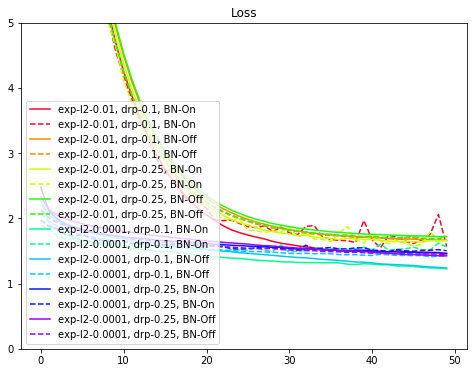

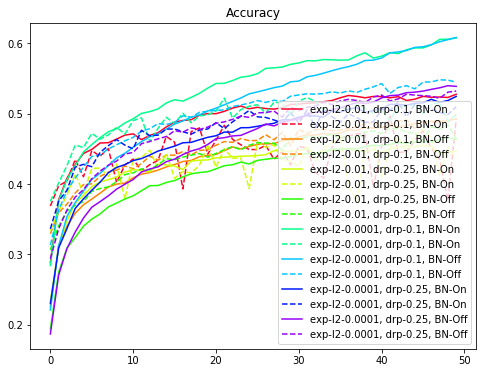

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()